In [1]:
import os
import pandas as pd
import numpy as np
import ujson as json
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from collections import OrderedDict

from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier

In [2]:
PATH_TO_DATA = './data/'
SEED = 17
SIZE = None

In [3]:
# def plot_PCA(pca):
#     components = range(1, pca.n_components_ + 1)
#     variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#     plt.figure(figsize=(20, 10))
#     plt.bar(components, variance)
    
#     plt.hlines(y=95, xmin=0, xmax=len(components), linestyles='dashed', colors='red')
    
#     plt.xlabel('PCA components')
#     plt.ylabel('variance')
#     plt.xticks(components)
#     plt.show()

In [4]:
# def get_scores(model, X, y):
#     cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
#     return cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)

In [5]:
def replace_na(df):
    df[np.isnan(df)] = 0
    df[np.isinf(df)] = 0
    return df

In [6]:
def read_matches(matches_file, size=None):
    with open(os.path.join(PATH_TO_DATA, matches_file)) as f:
        count = 0
        for line in f:
            if size is not None and count >= size:
                return
            count += 1
            yield json.loads(line)

In [7]:
# def add_hero_id_level(df):
#     for i in range(1, 6):
#         df[f'r{i}_hero_id_level'] = df[f'r{i}_hero_id'].astype(str) + '-' + df[f'r{i}_level'].astype(str)
#         df[f'd{i}_hero_id_level'] = df[f'd{i}_hero_id'].astype(str) + '-' + df[f'd{i}_level'].astype(str)
#     return df

In [8]:
def count_ruined_towers(match):
    radiant_tower_kills = 0
    dire_tower_kills = 0
    for objective in match['objectives']:
        if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
            if objective['team'] == 2:
                radiant_tower_kills += 1
            if objective['team'] == 3:
                dire_tower_kills += 1
    return radiant_tower_kills, dire_tower_kills

In [9]:
def count_players_feature(match, feature):
    radiant = 0
    dire = 0
    for slot, player in enumerate(match['players']):
        if slot < 5:
            radiant += player[feature]
        else:
            dire += player[feature]
    return radiant, dire

In [10]:
# def count_players_xp_minute(df):
#     cats = []
#     for i in range(1, 6):
#         df[f'r{i}_xp_minute'] = df[f'r{i}_xp'] / ((df['game_time'] + 90) / 60)
#         cats.append(f'r{i}_xp_minute')
#         df[f'd{i}_xp_minute'] = df[f'd{i}_xp'] / ((df['game_time'] + 90) / 60)
#         cats.append(f'd{i}_xp_minute')
#     df = df.fillna(0)
#     return df, tuple(cats)

In [11]:
# def count_damage(match):
#     radiant = 0
#     dire = 0
#     for slot, player in enumerate(match['players']):
#         if slot < 5:
#             radiant += sum(player['damage'].values())
#         else:
#             dire += sum(player['damage'].values())
#     return radiant, dire

In [12]:
def combine_numeric_features(df, feature_suffixes):
    for feat_suff in feature_suffixes:
        for team in 'r', 'd':
            players = [f'{team}{i}' for i in range(1, 6)]
            player_col_names = [f'{player}_{feat_suff}' for player in players]

            df[f'{team}_{feat_suff}_std'] = df[player_col_names].std(axis=1)
            df[f'{team}_{feat_suff}_mean'] = df[player_col_names].mean(axis=1)

            df.drop(columns=player_col_names, inplace=True)
        
        df[f'{feat_suff}_std_ratio'] = df[f'r_{feat_suff}_std'] / df[f'd_{feat_suff}_std']
        df[f'{feat_suff}_mean_ratio'] = df[f'r_{feat_suff}_mean'] / df[f'd_{feat_suff}_mean']

        df.drop(columns=[
            f'r_{feat_suff}_std', f'd_{feat_suff}_std',
            f'r_{feat_suff}_mean', f'd_{feat_suff}_mean',
        ], inplace=True)

    return df

In [13]:
def make_coordinate_features(df):
#     for team in 'r', 'd':
#         for player in [f'{team}{i}' for i in range(1, 6)]:
#             df[f'{player}_distance'] = np.sqrt(df[f'{player}_x']**2 + df[f'{player}_y']**2)
#             df.drop(columns=[f'{player}_x', f'{player}_y'], inplace=True)
#     return df

    r_y_coord = [f'r{i}_y' for i in range(1,6)]
    r_x_coord = [f'r{i}_x' for i in range(1,6)]
    d_y_coord = [f'd{i}_y' for i in range(1,6)]
    d_x_coord = [f'd{i}_x' for i in range(1,6)]

    for agg in ('mean', 'std'):
        df[f'r_y_{agg}'] = df[r_y_coord].agg(agg, axis=1)
        df[f'r_x_{agg}'] = df[r_x_coord].agg(agg, axis=1)
        df[f'd_y_{agg}'] = df[d_y_coord].agg(agg, axis=1)
        df[f'd_x_{agg}'] = df[d_x_coord].agg(agg, axis=1)
    df.drop(columns=r_y_coord+r_x_coord+d_y_coord+d_x_coord, inplace=True)
    return df

In [14]:
# def hero_id_subset_analyzer(text):
#     ids = set()
#     for i in range(1, 4):
#         hero_ids = text.split(' ')
#         hero_ids.sort() 
#         ids = ids.union(set(combinations(hero_ids, i)))
#     return { "_".join(item) for item in ids}

In [15]:
# def replace_hero_ids(df, vectorizer, train=True):
#     for team in 'r', 'd':
#         players = [f'{team}{i}' for i in range(1, 6)]
#         hero_columns = [f'{player}_hero_id' for player in players]
        
#         df_hero_id_as_text = df[hero_columns].apply(
#             lambda row: ' '.join([str(i) for i in row]), axis=1
#         ).tolist()
        
#         if train:
#             new_cols = pd.DataFrame(
#                 vectorizer.fit_transform(df_hero_id_as_text).todense(),
#                 columns=vectorizer.get_feature_names(),
#                 index=df.index.values
#             )
#         else:
#             new_cols = pd.DataFrame(
#                 vectorizer.transform(df_hero_id_as_text).todense(),
#                 columns=vectorizer.get_feature_names(),
#                 index=df.index.values
#             )
        
#         new_cols = new_cols.add_prefix(f'{team}_hero_')

#         df = pd.concat([df, new_cols], axis=1)
#         df.drop(columns=hero_columns, inplace=True)
#     return df

In [16]:
# def combine_hero_ids(df):
#     for team in ('r', 'd'):
#         cols = [f'{team}{i}_hero_id' for i in range(1, 6)]
#         df[f'{team}_hero_ids'] = df[cols].astype(str).apply(lambda row: '_'.join(sorted(row)), axis=1)
#         df.drop(columns=cols, inplace=True)
#     return df

In [17]:
def ohe_hero_ids(df):
    for team in ('r', 'd'):
        for i in range(1, 6):
            col = f'{team}{i}_hero_id'
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
            df.drop(columns=[col], inplace=True)
    return df

In [18]:
def get_some_player_features(match):
    row = [('match_id_hash', match['match_id_hash'])]
    for slot, player in enumerate(match['players']):
        player_name = f'r{slot + 1}' if slot < 5 else f'd{slot - 4}'
        row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
        row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
        row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
        row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
        row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
        row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))
    return row

In [19]:
def add_new_features(df_features, matches_file, size=None):
    df_features = df_features.copy()
    
    some_player_features = pd.DataFrame()
    for match in read_matches(matches_file, size=size):
        match_id = match['match_id_hash']

        radiant_tower_kills, dire_tower_kills = count_ruined_towers(match)
        df_features.loc[match_id, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills

        for feature in ('gold', 'xp', ):
            radiant, dire = count_players_feature(match, feature)
            df_features.loc[match_id, f'radiant_{feature}'] = radiant
            df_features.loc[match_id, f'dire_{feature}'] = dire
            df_features.loc[match_id, f'diff_{feature}'] = radiant - dire

        some_player_features = some_player_features.append(
            pd.DataFrame(
                OrderedDict(get_some_player_features(match)),
                index=[0]
            ).set_index('match_id_hash')
        )

    for col in ('radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills'):
        df_features[col] = df_features[col].fillna(0).astype('int')

    # df_features = pd.concat([df_features, some_player_features], axis=1, sort=False)
    
    df_features = make_coordinate_features(df_features)
    
    numeric_features = [
        'kills', 'deaths', 'assists', 'denies', 'gold', 'xp', 'health',
        'max_health', 'max_mana', 'level', 'towers_killed', 'stuns',
        'creeps_stacked', 'camps_stacked', 'lh', 'rune_pickups', 'firstblood_claimed',
        'teamfight_participation', 'roshans_killed', 'obs_placed', 'sen_placed',
#         'ability_level', 'max_hero_hit', 'purchase_count', 'count_ability_use',
#         'damage_dealt', 'damage_received', 'distance'
    ]
    df_features = replace_na(combine_numeric_features(df_features, numeric_features))

    df_features = ohe_hero_ids(df_features)
 
    return df_features

In [20]:
df_train = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'train_features.csv'), 
    index_col='match_id_hash'
)
df_targets = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'train_targets.csv'), 
    index_col='match_id_hash'
)
df_test = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'test_features.csv'), 
    index_col='match_id_hash'
)

In [21]:
df_train_ext = add_new_features(df_train, 'train_matches.jsonl', size=SIZE)[:SIZE]
df_targets_ext = df_targets[:SIZE]

In [22]:
# hero_id_vectorizer = TfidfVectorizer(
#     ngram_range=(1, 1),
#     max_features=1000,
#     tokenizer=lambda s: s.split(),
#     analyzer=hero_id_subset_analyzer
# )
# df_train_ext = replace_hero_ids(df_train_ext, vectorizer=hero_id_vectorizer)

In [23]:
# pca = PCA(n_components=10)
# X = pca.fit_transform(df_train_ext.values)
# y = df_targets_ext['radiant_win'].map({True: 1, False: 0}).values
# df_test_ext = pca.transform(df_test_ext.values)

X = df_train_ext
y = df_targets_ext['radiant_win'].map({True: 1, False: 0})

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

cat_features = [
    'objectives_len', 'game_mode',
    'radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills',
]
cat_features_idx = [X.columns.get_loc(i) for i in cat_features]

In [25]:
X.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,radiant_tower_kills,dire_tower_kills,diff_tower_kills,radiant_gold,dire_gold,...,d5_hero_id_107,d5_hero_id_108,d5_hero_id_109,d5_hero_id_110,d5_hero_id_111,d5_hero_id_112,d5_hero_id_113,d5_hero_id_114,d5_hero_id_119,d5_hero_id_120
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0,0,0,2037.0,3948.0,...,0,0,0,0,0,0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,2,0,2,18172.0,13144.0,...,0,0,0,0,0,0,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0,0,0,880.0,480.0,...,0,0,0,0,0,0,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,0,0,0,13348.0,11301.0,...,0,0,0,0,0,0,0,0,0,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0,0,0,8079.0,9177.0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
params = {
    'iterations': 500,
    'eval_metric': 'AUC',
    'custom_loss': ['AUC'],
    'random_state': SEED
}
model = CatBoostClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=cat_features_idx,
    verbose=False
);

In [27]:
print(model.best_score_['validation']['AUC'])

0.8304118322294307


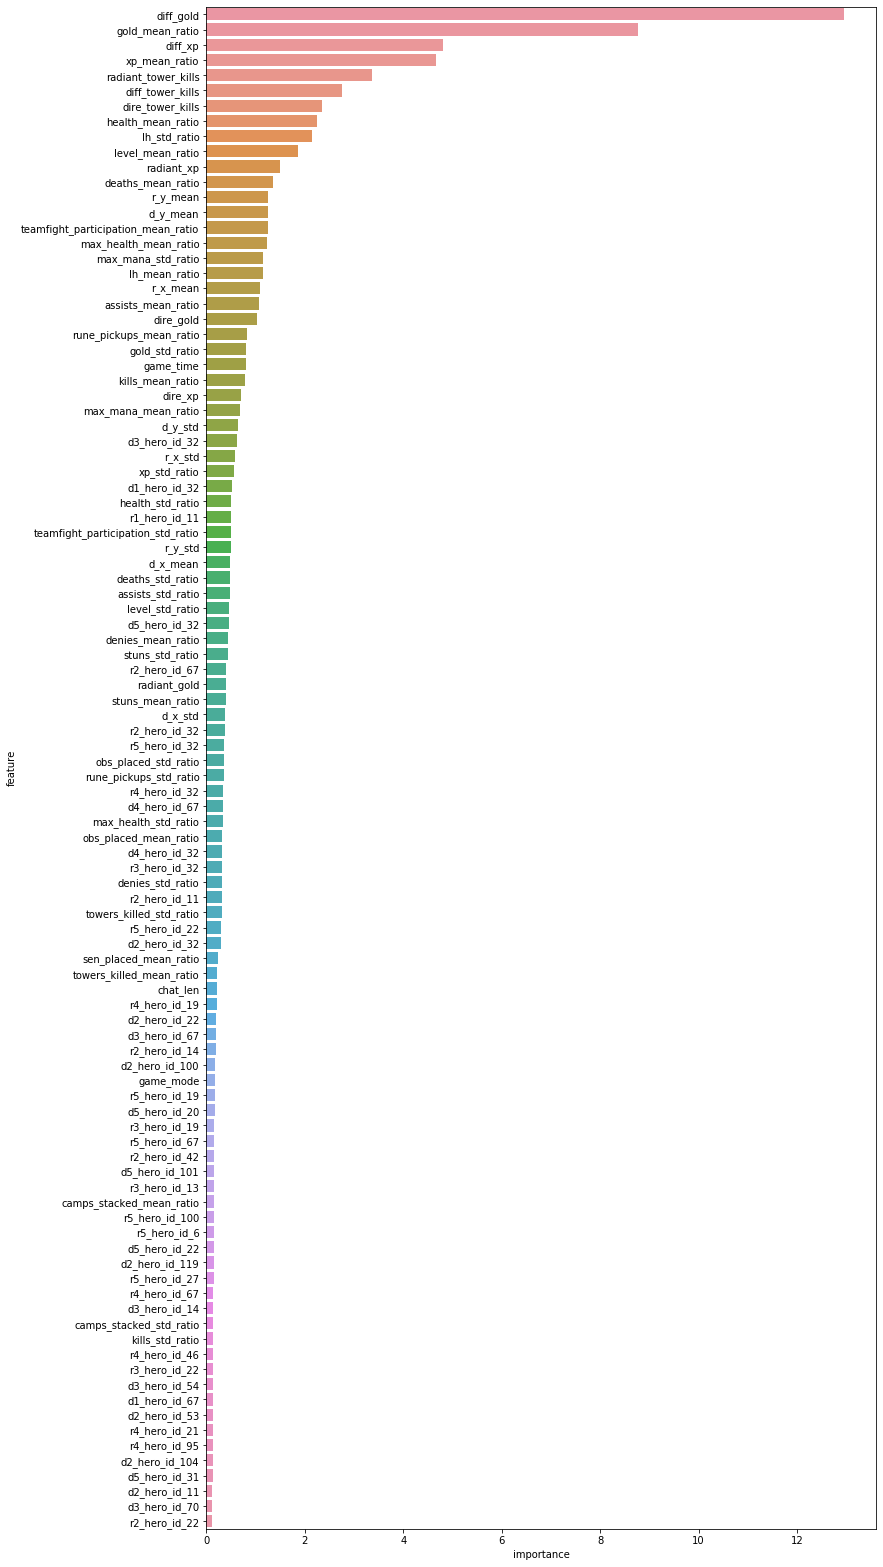

In [28]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)[:100]

plt.figure(figsize=(12,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature);

In [29]:
df_test_ext = add_new_features(df_test, 'test_matches.jsonl', size=SIZE)[:SIZE]
model.fit(
    df_train_ext,
    df_targets_ext['radiant_win'].map({True: 1, False: 0}),
    cat_features=cat_features_idx,
    verbose=False
)
y_pred = model.predict_proba(df_test_ext)[:, 1]
pd.DataFrame({'radiant_win_prob': y_pred}, index=df_test_ext.index).to_csv('submission.csv')

In [30]:
plt.figure(figsize=(16, 6))
sns.distplot(y_pred).set_title('Distribution of predictions');